# Milvus Multi Modal Search

## Disclaimers
- Use only Projects and Spaces that are available in watsonx context.

## Overview
### AUDIENCE
This notebook demonstrates the advanced features of Milvus 2.4, including multi-vector support and hybrid search capabilities.

The scenario in this notebook has a dataset comprising embeddings generated from diverse data modalities (e.g., text and images) stored in a csv file. It introduces 
- Milvus 2.4 multi-vector support and a hybrid search framework, which means we can bring in several vector fields (up to 10) into a single collection.
- These vectors in different columns represent diverse facets of data, originating from different embedding models or undergoing distinct processing methods.
- The results of hybrid searches are integrated using reranking strategies, such as Reciprocal Rank Fusion (RRF) and Weighted Scoring.

Some familiarity with Python, vector embeddings, and basic database concepts is helpful. This notebook is compatible with Python 3.12.
### Learning goal
This notebook demonstrates using multi-vector support and a hybrid search framework in watsonx.data, introducing commands for:
- Connecting to Milvus
- Creating collections
- Creating indexes
- Ingesting data
- Querying

### About Milvus
[Visit Milvus Documentation](https://milvus.io/docs/)

Milvus is an open-source vector database designed specifically for scalable similarity search and AI applications. It's a powerful platform that enables efficient storage, indexing, and retrieval of vector embeddings, which are crucial in modern machine learning and artificial intelligence tasks.

### Milvus: Three Fundamental Steps

#### 1. Data Preparation
Collect and convert your data into high-dimensional vector embeddings. These vectors are typically generated using machine learning models like neural networks, which transform text, images, audio, or other data types into dense numerical representations that capture semantic meaning and relationships.

#### 2. Vector Insertion
Load the dense vector embeddings and sparse vector embeddings into Milvus collections or partitions within a database. Milvus creates indexes to optimize subsequent search operations, supporting various indexing algorithms like IVF-FLAT, HNSW, etc., based on the definition.

#### 3. Similarity Search
Perform vector similarity searches by providing a query vector and a reranking weight. Milvus will rapidly return the most similar vectors from the collection or partitions based on the defined metrics like cosine similarity, Euclidean distance, or inner product and the reranking weight.

### Multi modal Search Use cases
Multi-modal search refers to a search system capable of processing and retrieving information based on multiple data modalities, such as text, images, audioetc. Instead of limiting searches to a single modality, multi-modal search integrates diverse data types to deliver richer, more relevant results. This allows cross-modal interactions which provides embeddings from different modalities to provide more contextually relevant results.

Some use cases include :
- Content-Based Image Retrieval (CBIR)
- Medical Imaging
- Cross-Modal Search in Social Media



### Key Workflow

1. **Definition** (once)
2. **Ingestion** (once)
3. **Retrieve relevant passage(s)** (for every user query)

## Contents

- Environment Setup
- Import libraries
- Data loading
- Create connection
- Ingest data
- Query
## Environment Setup

Before using the sample code in this notebook, complete the following setup tasks:

- Create a Watsonx.data instance (a free plan is offered)
  - Information about creating a watsonx.data instance can be found [here](https://www.ibm.com/docs/en/watsonx/watsonxdata/2.0.x)

## Import Libraries

This notebook uses sentence transformer to generate vector embeddings.

In [ ]:
#!pip install pymilvus
# Restart Kernal

In [1]:
%%capture
!pip show pymilvus


Name: pymilvus
Version: 2.4.0
Summary: Python Sdk for Milvus
Home-page: 
Author: 
Author-email: Milvus Team <milvus-team@zilliz.com>
License: 
Location: /Users/swatikarot/Downloads/milvus/myenv/lib/python3.12/site-packages
Requires: azure-storage-blob, environs, grpcio, minio, pandas, protobuf, pyarrow, requests, scipy, setuptools, ujson
Required-by: 


In [24]:
!pip install pandas pillow ipython

  Using cached pillow-10.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
Using cached pillow-10.3.0-cp312-cp312-macosx_11_0_arm64.whl (3.4 MB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


## Fetch Data

The dataset consists of 5 products and 10 reviews for each product. 
- The first product named 'BestProductA' has all possitive reviews.
- The second product named 'GoodProductB' has mostly possitive reviews, very few negative or neutral reviews.
- The third product named 'AverageProductC' has mostly mixed or neutral reviews.
- The fourth product named 'BadProductD' has mostly negative reviews, very few positive or neutral reviews.
- The fifth product named 'WorstProductE' has all negative reviews.

For the sake of getting a hint on the overall product quality, the product names have been choosen likewise. It has no effect on similarity calculation.

You can either create your own dataset tailored to your specific needs or source one from reputable online repositories. Make sure it has the following columns.

In [25]:
import pickle

with open('./data/preprocessed_df.pkl', "rb") as openfile:
    preprocessed_df = pickle.load(openfile)


/var/folders/27/fcf4w5d93djfxhslly4vj6j40000gn/T/ipykernel_26399/912622302.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  preprocessed_df = pickle.load(openfile)


,data,text_path,image_path,media_type,text_embeddings,image_embeddings,image,text
0,bear,../data/text/bear.txt,../data/images/bear1.jpg,text,"[-0.5404721, 1.5690618, 2.6174855, -1.1754416,...","[0.011310808, -0.019132396, -0.022592165, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,"Bears are large mammals with a stocky body, po..."
1,bat,../data/text/bat.txt,../data/images/bat1.jpg,text,"[-1.1327577, 4.4052844, -0.08142696, 0.8501287...","[-0.006592049, 0.027778821, -0.022019383, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,Bats are the only mammals capable of sustained...
2,deer,../data/text/deer.txt,../data/images/deer1.jpg,text,"[0.8241224, 3.2268438, 3.307532, 0.47642612, -...","[0.0075792605, 0.0073336903, 0.04133869, 0.013...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,Deer are hoofed mammals known for their gracef...
3,hedgehog,../data/text/hedgehog.txt,../data/images/hedgehog1.jpg,text,"[-0.5404721, 1.5690618, 2.6174855, -1.1754416,...","[0.022487547, -1.5443937e-05, -0.0180075, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,"Hedgehogs are small, nocturnal mammals known f..."
4,caterpillar,../data/text/caterpillar.txt,../data/images/caterpillar1.jpg,text,"[-1.083732, 3.8729773, 2.3686168, 0.439042, -2...","[0.033966806, 0.016641296, 0.024822084, -0.018...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,Caterpillars are the larval stage of butterfli...
5,fox,../data/text/fox.txt,../data/images/fox1.jpg,text,"[0.8782075, 1.8314755, 4.31653, 0.12236622, -2...","[0.0037645553, -0.022698667, 0.026629105, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,"Foxes are small to medium-sized, omnivorous ma..."


In [37]:
preprocessed_df['id']= [i for i in range(preprocessed_df.shape[0])]
preprocessed_df

,data,text_path,image_path,media_type,text_embeddings,image_embeddings,image,text,id
0,bear,../data/text/bear.txt,../data/images/bear1.jpg,text,"[-0.5404721, 1.5690618, 2.6174855, -1.1754416,...","[0.011310808, -0.019132396, -0.022592165, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,"Bears are large mammals with a stocky body, po...",0
1,bat,../data/text/bat.txt,../data/images/bat1.jpg,text,"[-1.1327577, 4.4052844, -0.08142696, 0.8501287...","[-0.006592049, 0.027778821, -0.022019383, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,Bats are the only mammals capable of sustained...,1
2,deer,../data/text/deer.txt,../data/images/deer1.jpg,text,"[0.8241224, 3.2268438, 3.307532, 0.47642612, -...","[0.0075792605, 0.0073336903, 0.04133869, 0.013...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,Deer are hoofed mammals known for their gracef...,2
3,hedgehog,../data/text/hedgehog.txt,../data/images/hedgehog1.jpg,text,"[-0.5404721, 1.5690618, 2.6174855, -1.1754416,...","[0.022487547, -1.5443937e-05, -0.0180075, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,"Hedgehogs are small, nocturnal mammals known f...",3
4,caterpillar,../data/text/caterpillar.txt,../data/images/caterpillar1.jpg,text,"[-1.083732, 3.8729773, 2.3686168, 0.439042, -2...","[0.033966806, 0.016641296, 0.024822084, -0.018...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,Caterpillars are the larval stage of butterfli...,4
5,fox,../data/text/fox.txt,../data/images/fox1.jpg,text,"[0.8782075, 1.8314755, 4.31653, 0.12236622, -2...","[0.0037645553, -0.022698667, 0.026629105, -0.0...",<PIL.JpegImagePlugin.JpegImageFile image mode=...,"Foxes are small to medium-sized, omnivorous ma...",5


## Connect to Milvus

In [29]:
fmt = "\n=== {:30} ===\n"
num_entities, dim = 50, 1024  # Adjusted for more entities and higher dimension
BATCH_SIZE = 5
collection_name="mm_collection"

In [1]:
from pymilvus import MilvusClient, DataType, CollectionSchema, FieldSchema,utility,connections,Collection

In [ ]:
# Replace Placeholder Values <> with respective provisioned Milvus Values .
"""# On Prem
connections.connect(
            alias='default',
            host="<>",
            port=443,
            secure=True,
            server_pem_path="",
            server_name="<>",
            user="<>",
            password="<>")"""
# SaaS
connections.connect(
            alias='default',
            host="<>",
            port="<>",
            secure=True,
            user="<>",
            password="<>")

## Create collection 
[more about collections](https://milvus.io/docs/manage-collections.md)

In [34]:
# Create schema
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True),
    FieldSchema(name="text_embeddings", dtype=DataType.FLOAT_VECTOR, dim=dim), # Vector field for film vectors
    FieldSchema(name="image_embeddings", dtype=DataType.FLOAT_VECTOR, dim=dim)] # Vector field for poster vectors

schema = CollectionSchema(fields=fields,enable_dynamic_field=False)

# Create collection
collection = Collection(name="mm_collection", schema=schema)

## Create index and insert data 
[more on indexes](https://milvus.io/docs/index-vector-fields.md)

In [44]:

import pandas as pd
import ast

index_params = {
    "metric_type": "L2",
    "index_type": "IVF_FLAT",
    "params": {"nlist": 128},
}

#create index
collection.create_index("text_embeddings", index_params)
collection.create_index("image_embeddings", index_params)


# Load your DataFrame
df = preprocessed_df[['id','text_embeddings','image_embeddings']]

# List to store the entities
entities = []

# Iterate through the DataFrame rows
for index, row in df.iterrows():
   
    # Create a dictionary for each entity
    entity = {
        "id": row['id'],
        "text_embeddings": row['text_embeddings'],
        "image_embeddings": row['image_embeddings']
    }
    
    # Add the entity to the list
    entities.append(entity)

# Insert the entities into the collection
collection.insert(entities)



(insert count: 6, delete count: 0, upsert count: 0, timestamp: 450754131706773506, success count: 6, err count: 0)

## Text based query embedding

In [165]:
import pickle

with open('./data/query_embeddings.pkl', "rb") as openfile:
    query_embeddings = pickle.load(openfile)
query_embeddings

/var/folders/27/fcf4w5d93djfxhslly4vj6j40000gn/T/ipykernel_26399/2448739131.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  query_embeddings = pickle.load(openfile)


,query_id,query_text,embeddings
0,0,brown animal with antlers,"[4.5750923, 3.471852, 3.454464, 0.50423515, -2..."
1,1,green and yellow insect that cocoons,"[-3.5080485, -2.0328262, 1.6813948, 0.07501351..."
2,2,what is a bat?,"[1.126978, -0.02785295, 2.672513, 4.200401, -3..."


## Image based query embedding 

In [166]:
import pickle

with open('./data/query_image_embeddings.pkl', "rb") as openfile:
    query_image_embeddings = pickle.load(openfile)
query_image_embeddings

/var/folders/27/fcf4w5d93djfxhslly4vj6j40000gn/T/ipykernel_26399/2457774589.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  query_image_embeddings = pickle.load(openfile)


,query_id,embeddings
0,0,"[-0.015404081, 0.006553277, -0.005401999, 0.01..."
1,1,"[0.008140958, 0.018523317, 0.024238558, -0.022..."
2,2,"[0.024771081, -0.0030838004, 0.0018066134, 0.0..."


In [174]:
question_text = query_embeddings['query_text'][1]
question_text_vector = query_embeddings['embeddings'][1]
question_image_vector = query_image_embeddings['embeddings'][1]


## Query

In [184]:
from pymilvus import AnnSearchRequest


search_param_1 = {
    "data": [question_text_vector], # Query vector
    "anns_field": "text_embeddings", # Vector field name
    "param": {
        "metric_type": "L2", # This parameter value must be identical to the one used in the collection schema
        "params": {"nprobe": 10}
    },
    "limit": 2 # Number of search results to return in this AnnSearchRequest
}
request_1 = AnnSearchRequest(**search_param_1)

search_param_2 = {
    "data": [question_image_vector], # Query vector
    "anns_field": "image_embeddings", # Vector field name
    "param": {
        "metric_type": "L2", # This parameter value must be identical to the one used in the collection schema
        "params": {"nprobe": 10}
    },
    "limit": 2 # Number of search results to return in this AnnSearchRequest
}
request_2 = AnnSearchRequest(**search_param_2)

reqs = [request_1, request_2]


In [185]:
from pymilvus import WeightedRanker
rerank = WeightedRanker(0.8, 0.2)  


In [186]:
collection.load()

res = collection.hybrid_search(
    reqs, # List of AnnSearchRequests created in step 1
    rerank, # Reranking strategy specified in step 2
    limit=1, # Number of final search results to return
    output_fields=["id"]
)

print(res[0])


["id: 4, distance: 0.1376328319311142, entity: {'id': 4}"]


In [187]:
for hit in res[0]:
    hit_id = hit.id
    print(hit_id)


4


In [188]:
import pandas as pd
import re

# Filter DataFrame using the extracted id values
filtered_df = preprocessed_df[preprocessed_df['id']==(hit.id)]

print(filtered_df)


          data                     text_path                       image_path  \
4  caterpillar  ../data/text/caterpillar.txt  ../data/images/caterpillar1.jpg   

  media_type                                    text_embeddings  \
4       text  [-1.083732, 3.8729773, 2.3686168, 0.439042, -2...   

                                    image_embeddings  \
4  [0.033966806, 0.016641296, 0.024822084, -0.018...   

                                               image  \
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                text  id  
4  Caterpillars are the larval stage of butterfli...   4  


Data: caterpillar


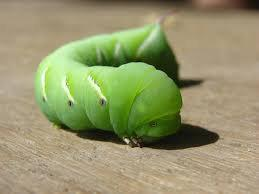

Text: Caterpillars are the larval stage of butterflies and moths. They have a segmented body with a distinct head and typically several pairs of true legs, as well as additional false legs or prolegs. Caterpillars are primarily known for their voracious appetite, often eating leaves voraciously before pupating into their adult form.



In [189]:
# Display images inline in Jupyter Notebook
def display_images(df):
    for idx, row in df.iterrows():
        print(f"Data: {row['data']}")
        display(row['image'])
        print(f"Text: {row['text']}\n")
        

# Call the function to display images and text
display_images(filtered_df)